In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# Load dataset
df = pd.read_csv("Cost_of_Living_Index_2022.csv")

# Inspect structure
print(df.shape)
print(df.columns.tolist())
df.head()


(139, 8)
['Rank', 'Country', 'Cost of Living Index', 'Rent Index', 'Cost of Living Plus Rent Index', 'Groceries Index', 'Restaurant Price Index', 'Local Purchasing Power Index']


,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,1,Afghanistan,20.37,2.72,12.09,14.92,12.41,23.04
1,2,Albania,35.50,8.47,22.83,29.32,25.82,30.19
2,3,Algeria,26.87,4.59,16.43,28.82,14.48,24.63
3,4,Argentina,34.69,7.71,22.04,28.17,33.32,30.72
4,5,Armenia,33.89,11.61,23.45,27.59,30.55,28.86


In [3]:
df.columns = df.columns.str.strip().str.lower()
print(df.columns.tolist())


['rank', 'country', 'cost of living index', 'rent index', 'cost of living plus rent index', 'groceries index', 'restaurant price index', 'local purchasing power index']


In [4]:
print(df.info())
print(df.describe())
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   rank                            139 non-null    int64  
 1   country                         139 non-null    object 
 2   cost of living index            139 non-null    float64
 3   rent index                      139 non-null    float64
 4   cost of living plus rent index  139 non-null    float64
 5   groceries index                 139 non-null    float64
 6   restaurant price index          139 non-null    float64
 7   local purchasing power index    139 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 8.8+ KB
None
             rank  cost of living index  rent index  \
count  139.000000            139.000000  139.000000   
mean    70.000000             50.188633   19.291511   
std     40.269923             20.860222   15.317726   

In [5]:
# Top 10 expensive countries
top10_exp = df.nlargest(10, 'cost of living index')[['country','cost of living index']]
print(top10_exp)

# 10 cheapest countries
top10_cheap = df.nsmallest(10, 'cost of living index')[['country','cost of living index']]
print(top10_cheap)


         country  cost of living index
15       Bermuda                146.04
119  Switzerland                123.35
90        Norway                100.90
51       Iceland                 94.86
11      Barbados                 92.37
62        Jersey                 92.02
57        Israel                 88.05
32       Denmark                 84.12
8        Bahamas                 84.00
109    Singapore                 83.98
                         country  cost of living index
92                      Pakistan                 19.92
0                    Afghanistan                 20.37
52                         India                 24.43
26                      Colombia                 26.72
2                        Algeria                 26.87
66   Kosovo (Disputed Territory)                 27.05
133                   Uzbekistan                 27.31
125                      Tunisia                 27.87
84                         Nepal                 28.29
126                  

C:\Users\bindh\AppData\Local\Temp\ipykernel_19436\3693226792.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cost of living index', y='country',


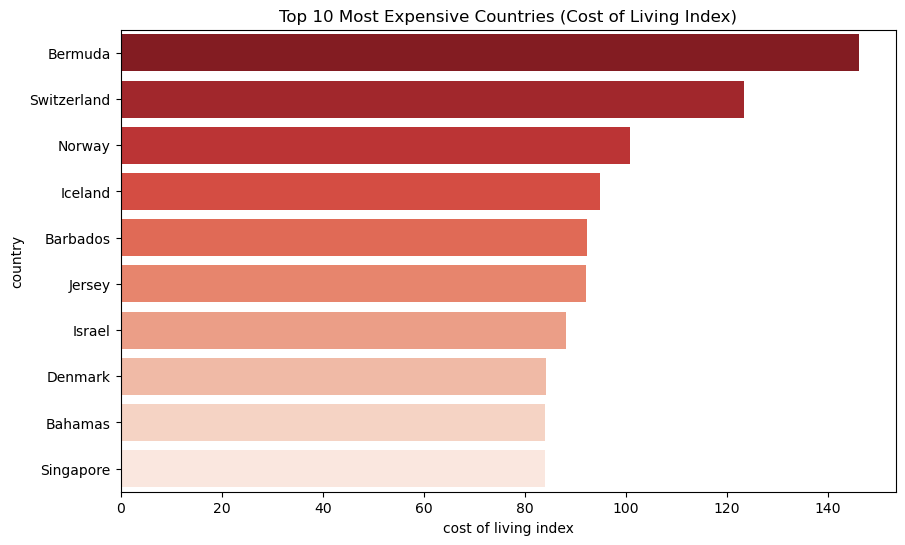

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x='cost of living index', y='country', 
            data=top10_exp, palette='Reds_r')
plt.title("Top 10 Most Expensive Countries (Cost of Living Index)")
plt.show()


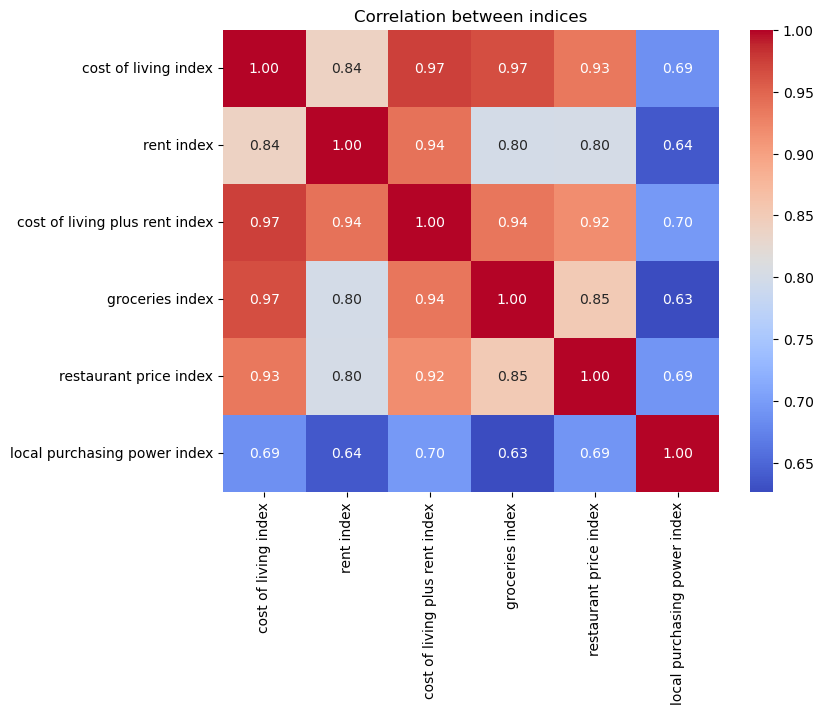

In [7]:
idx_cols = [
    'cost of living index',
    'rent index',
    'cost of living plus rent index',
    'groceries index',
    'restaurant price index',
    'local purchasing power index'
]

plt.figure(figsize=(8,6))
sns.heatmap(df[idx_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between indices")
plt.show()


In [8]:
df['highest index'] = df[idx_cols].idxmax(axis=1)
df[['country','highest index']].head(15)


,country,highest index
0,Afghanistan,local purchasing power index
1,Albania,cost of living index
2,Algeria,groceries index
3,Argentina,cost of living index
4,Armenia,cost of living index
5,Australia,local purchasing power index
6,Austria,local purchasing power index
7,Azerbaijan,cost of living index
8,Bahamas,restaurant price index
9,Bahrain,local purchasing power index


In [9]:
print("Top 5 Rent Index countries:")
print(df[['country','rent index']].sort_values('rent index', ascending=False).head(5))

print("\nTop 5 Groceries Index countries:")
print(df[['country','groceries index']].sort_values('groceries index', ascending=False).head(5))

print("\nTop 5 Restaurant Price Index countries:")
print(df[['country','restaurant price index']].sort_values('restaurant price index', ascending=False).head(5))


Top 5 Rent Index countries:
        country  rent index
15      Bermuda       98.58
49    Hong Kong       74.57
109   Singapore       66.43
62       Jersey       65.33
72   Luxembourg       60.09

Top 5 Groceries Index countries:
         country  groceries index
15       Bermuda           148.66
119  Switzerland           128.13
90        Norway            97.31
114  South Korea            91.95
51       Iceland            90.22

Top 5 Restaurant Price Index countries:
         country  restaurant price index
15       Bermuda                  159.17
119  Switzerland                  122.09
90        Norway                  105.49
51       Iceland                   99.42
32       Denmark                   98.75


In [10]:
# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[idx_cols])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# View cluster profiles
cluster_summary = df.groupby('cluster')[idx_cols].mean().round(2)
print(cluster_summary)


c:\Users\bindh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


         cost of living index  rent index  cost of living plus rent index  \
cluster                                                                     
0                       34.91       10.42                           23.43   
1                       77.11       38.23                           58.89   
2                       51.79       17.27                           35.61   
3                      134.70       76.06                          107.21   

         groceries index  restaurant price index  local purchasing power index  
cluster                                                                         
0                  32.38                   25.78                         27.71  
1                  71.46                   74.58                         81.95  
2                  47.69                   45.31                         49.01  
3                 138.39                  140.63                         99.76  


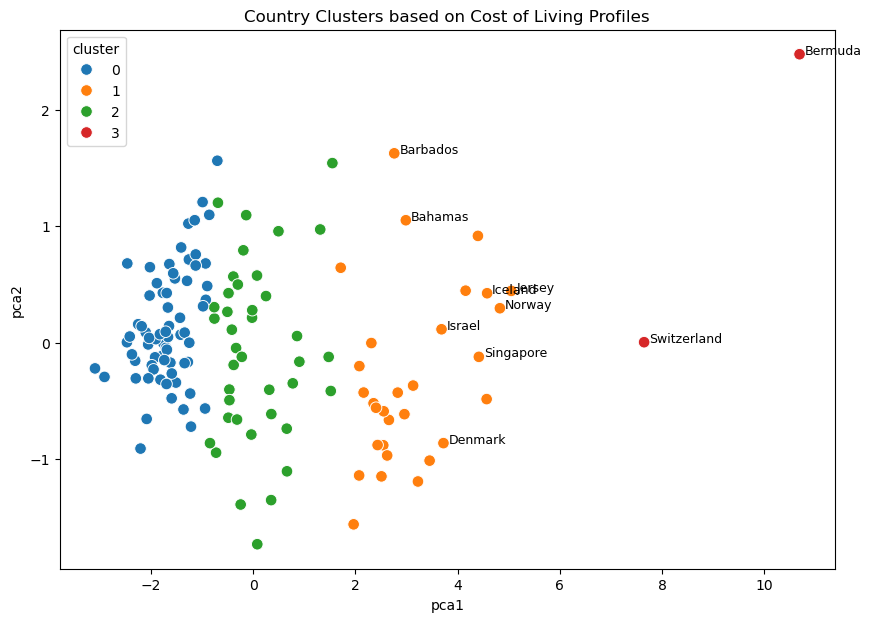

In [11]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)
df['pca1'] = pca_coords[:,0]
df['pca2'] = pca_coords[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10', s=70)

# Label top 10 expensive countries
for i, row in df.iterrows():
    if row['country'] in top10_exp['country'].values:
        plt.text(row['pca1']+0.1, row['pca2'], row['country'], fontsize=9)

plt.title("Country Clusters based on Cost of Living Profiles")
plt.show()


In [12]:
df.to_csv("Cost_of_Living_with_clusters.csv", index=False)
